# Assignment 2: Kernels
By Group 4: Qianjing Liang, Elouise Matthews, Naman Ratra, Luis Sejas

## Introduction

On this assignment, we explore nonlinear kernel classification with its implementation on a dataset.\
Since our kernel choice depends on our dataset, an overview of our dataset is required. Our dataset is made of images from Messidor software. We do not actually use the images, but the features of the image to classify whether the patient has diabetic retinopathy or not. It is an univariate classification (1 = has diabetic retinopathy or 0 = otherwise.)

Even though the task states nonlinear and rbf kernels, we will use linear and sigmoid kernels as well for a full comparison.

Nystroem approximators were used initially to create surrogate data, but fortunately the dataset was small enough that the computing time was sufficiently short to complete the project within given time constrains. Using a subset of the data was also an option - which also did not need to be implemented. 

There are 3 main hyperparameters which will be tuned to improve our model:

- C: this is the control error, tuning this allows us to be stricter or looser with the error margin. Finding the right balance is key for avoiding overfitting or underfittting.

- gamma: Hyperparameter applicable for the rbf, sigmoid and polynomial kernels.

- degree: Only applicable to polynomial kernels and defines the highest degree polynomial admissible. 

Note: The scikit-learn library has a gamma attribute on the other kernel methods, but it is not applied the same way as it is in rbf. It consists mainly of a scalar.

## Structure: 
1. Import data and prepare features and target variables. 
2. plot performance curves for $f_{1}$ and $f_{2}$ scores, using poly/rbf kernels, varying gamma, C, and degrees individually
3. plot performance curves for $f_{1}$ and Recall scores, using poly/rbf kernels, varying gamma, C, and degrees individually
4. Initial rough grid search for 4 different kernels and a wide range of parameters
5. Second round of grid search with narrower ranges of hyperparameters, and apply combinations of hyperparameters that maximize $f_{1}$ and Recall respectively to a final run and observe their confusion matrices

## Part 1. 

In [1]:
import time 
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import fbeta_score, make_scorer, recall_score
import matplotlib.pyplot as plt 
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.model_selection import validation_curve 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample 
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib.colors import Normalize
import warnings
warnings.filterwarnings("ignore")

# data source: 
# https://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set#
data = pd.read_csv('messidor_features.csv')
data.head(3)

# Remove the column "id" since it's not useful for the model
data = data.drop('id',axis=1)
data.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,Class
0,1,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1


In [2]:
#Load dataset and split into X and y
X = data.iloc[:,:19]
y = data.iloc[:,19]

print(X.shape)
# The dataset is quite balanced.
print('Observations that contain signs of Diabetic Retinopathy: ' + \
      str(round(y.sum()/len(y) * 100, 4)) + '%.')
# The dataset doesn't have null values.
print('Number of null values in the data: ',X.isnull().sum().sum())

(1151, 19)
Observations that contain signs of Diabetic Retinopathy: 53.0843%.
Number of null values in the data:  0


In [3]:
# Split into train and test set and normalize data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Part 2. 

Initially the two metrics for model comparison will be the $f_{1}$ score and the $f_{2}$ score. While increasing the value of Recall can help detect Diabetic Retinopathy sooner, increasing the value of Precision can avoid unnecessary waste of resources (e.g., due to additional examinations for false positive patients). \
By using $f_{1}$ metric, the model that optimizes this score will be making more balanced decisions that emphasize Recall and Precision equally. By using the $f_{2}$ metric, the model that optimizes this score will place more importance on increasing Recall (i.e. avoiding false negatives).

In [4]:
# Make f1 a valid validation
def f1_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta = 1, average = 'binary')

f1 = make_scorer(f1_scorer, greater_is_better=True)

# Make f2 a valid validation
def f2_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta = 2, average = 'binary')

f2 = make_scorer(f2_scorer, greater_is_better=True)

# Make recall a valid validation
def recall_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return recall_score(y_true, y_pred, average='macro')

recall = make_scorer(recall_scorer, greater_is_better=True)

In [5]:
# SVM with polynomial and rbf kernels for f1 and f2 scoring
# Hyperparameters adjusted include C, gamma ,and 
# degree (only for polynomial model)

def plot_svm_curve(model, gammas = 'auto', Cs = 1, degrees = 3):
    '''
    Returns two plots that show the changes in f1 and f2 scores as
    the desired hyperparameter varies.
        Parameters:
            model (str): the kernel to be used for the svm, can only
                be either "rbf" or "poly"
            gammas/Cs/degrees (numpy array): hyperparameter range for 
                the kernels; only one of these should be specified while
                the others remain fixed at their defaulted values
    '''
    num_splits = 5
    kfold = KFold(n_splits = 5,random_state = 0) 

    hyper_dict = {'gamma': gammas, 'C': Cs, 'degree': degrees}
    hypers = [gammas, Cs, degrees]
    for i in range(3):
        if type(hypers[i]) == np.ndarray: # select the varying hyperparameters
            hypers[i] = None
            if model == 'rbf':
                svm_model= svm.SVC(kernel = model, gamma = hypers[0], 
                           C = hypers[1])
            else:
                svm_model= svm.SVC(kernel = model, gamma = hypers[0], 
                                   C = hypers[1], degree = hypers[2])
            num_values = len(list(hyper_dict.values())[i])
            hyper_name = list(hyper_dict.keys())[i]
            hyper_value = list(hyper_dict.values())[i]
            break
    
    scorings = [f1, f2]
    fig1, ax1 = plt.subplots(1,2,figsize=(14,5),constrained_layout=True)
    for i in range(2):
        scoring = scorings[i]
        train_scores, valid_scores = validation_curve(svm_model, X_train, 
                                                      y_train, hyper_name, 
                                                      hyper_value, cv=kfold, 
                                                      scoring = scoring)
        train_scores_df = pd.DataFrame(data = train_scores, 
                                       index = np.arange(0, num_values), 
                                       columns = np.arange(0, num_splits)) 
        valid_scores_df = pd.DataFrame(data = valid_scores,
                                       index = np.arange(0, num_values), 
                                       columns = np.arange(0, num_splits)) 
        # plotting training and validation scores
        ax1[i].plot(hyper_value, train_scores_df.mean(axis=1), 
                    label = 'Training')
        ax1[i].plot(hyper_value, valid_scores_df.mean(axis=1), 
                    label = 'Test')
        # setting up title, label, legend, and the range of y axis to be shown
        ax1[i].set_title('SVM with ' + model + ' kernel')
        ax1[i].set_xlabel(hyper_name)
        ax1[i].legend()
        if hyper_name == 'C':
            ax1[i].set_ylim(0.45,1)
        elif hyper_name == 'gamma':
            ax1[i].set_ylim(0,1.05)
        else:
            ax1[i].set_ylim(0,1)
    ax1[0].set_ylabel('f1 score')
    ax1[1].set_ylabel('f2 score')

In [6]:
start_0 = time.time()
# define ranges of values for target hyperparameters 
degrees = np.arange(2, 21, 1)
Cs = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                   np.arange(10, 20, 2)), 
               np.arange(20, 101, 5)))
gammas = np.exp(np.arange(-5, 1, 0.2))

### Plottings of models using polynomial kernel with varying hyperparameters (metrics: $f_{1}$ and $f_{2}$ scores)

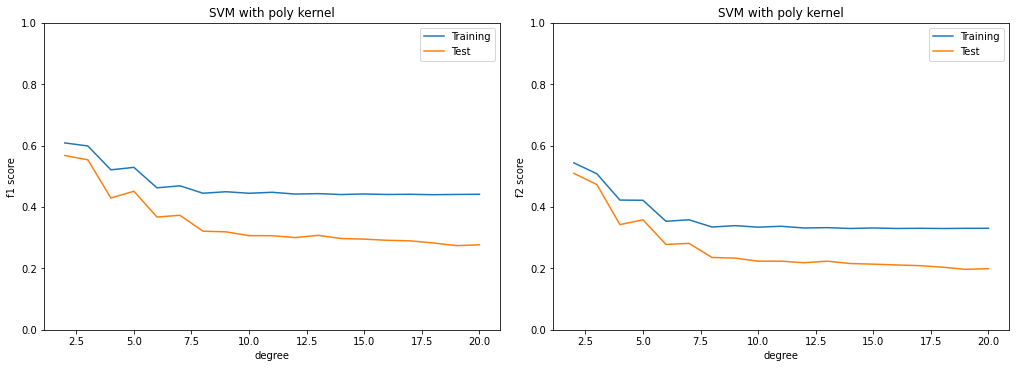

In [7]:
# varying degrees of the kernel
plot_svm_curve(model = 'poly', degrees = degrees)

Observation: \
(1) From the plot on the left side, it can be seen that as the value of degree increases, the $f_{1}$ score gradually decreases while the difference of the $f_{1}$ scores between training and test becomes larger.\
(2) From the plot on the right side, a similar observation can be made: as the degree increases, $f_{2}$ score decreases and the difference of the $f_{2}$ scores between training and test widens.\
In both cases, the scores have become stable once the value of degree reaches around 10.

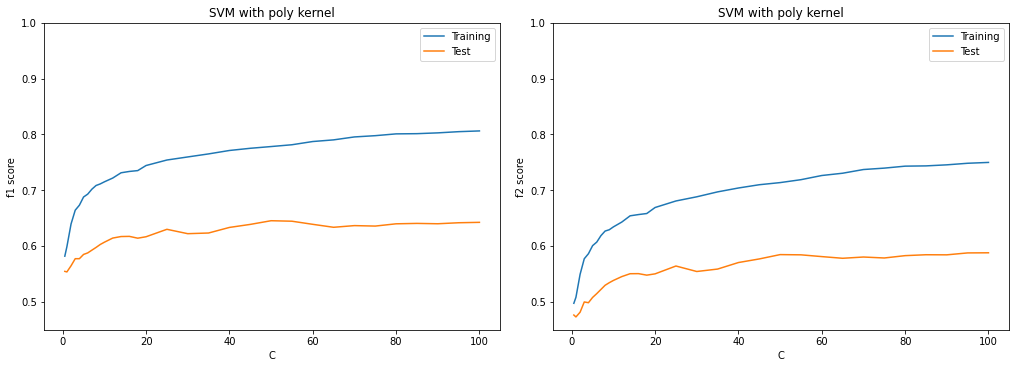

In [8]:
# varying the value of C of the kernel
plot_svm_curve(model = 'poly', Cs = Cs)

Observation: \
(1) From the plot on the left side, it can be seen that as the value of C increases, the $f_{1}$ score gradually increases while the difference of the $f_{1}$ scores between training and test becomes larger. Moreover, the increase in C has a larger effect on the training score than the test score.\
(2) From the plot on the right side, a similar observation can be made: as C increases, $f_{2}$ score increases and the difference of the $f_{2}$ scores between training and test widens. Meanwhile, the increase in C has a larger effect on the training score than the test score.\
In both cases, the scores have become stable once C reaches around 60.

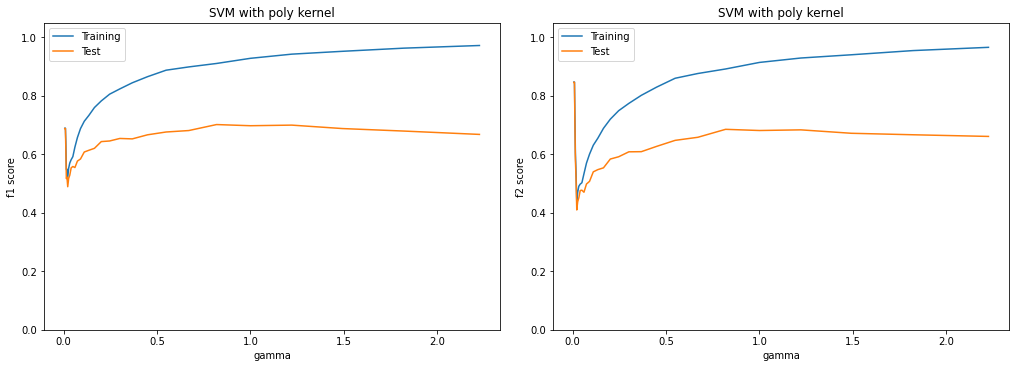

In [9]:
# varying the value of gamma of the kernel
plot_svm_curve(model = 'poly', gammas = gammas)

Observation: \
(1) From the plot on the left side, it can be seen that as the value of gamma increases, the $f_{1}$ score gradually increases (except when the value of gamma was very low) while the difference of the $f_{1}$ scores between training and test becomes larger. Moreover, the increase in gamma has a larger effect on the training score than the test score.\
(2) From the plot on the right side, a similar observation can be made: as gamma increases, $f_{2}$ score increases (except when the value of gamma was very low) and the difference of the $f_{2}$ scores between training and test widens. Meanwhile, the increase in gamma has a larger effect on the training score than the test score.\
In both cases, the exceptions occur when gamma was lower than around 0.05 and the scores have become stable once gamma reaches around 1.2.

### Plottings of models using rbf kernel with varying hyperparameters

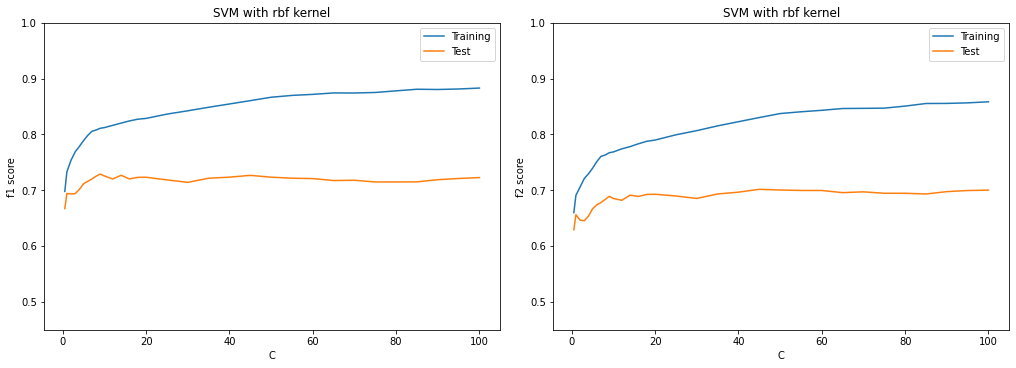

In [10]:
# varying the value of C of the kernel
plot_svm_curve(model = 'rbf', Cs = Cs)

Observation: \
(1) From the plot on the left side, it can be seen that as the value of C increases, the $f_{1}$ score gradually increases while the difference of the $f_{1}$ scores between training and test becomes larger. Moreover, the increase in C has a larger effect on the training score than the test score.\
(2) From the plot on the right side, a similar observation can be made: as C increases, $f_{2}$ score increases and the difference of the $f_{2}$ scores between training and test widens. Meanwhile, the increase in C has a larger effect on the training score than the test score.\
In both cases, the scores have become stable once C reaches around 60.

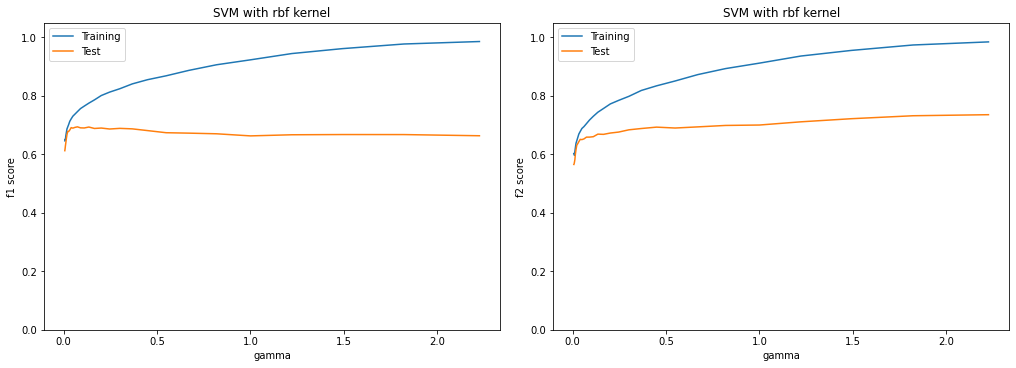

In [11]:
# varying the value of gamma of the kernel
plot_svm_curve(model = 'rbf', gammas = gammas)

Observation: \
(1) From the plot on the left side, it can be seen that as the value of gamma increases, the $f_{1}$ score gradually increases while the difference of the $f_{1}$ scores between training and test becomes larger. Moreover, the increase in gamma has a larger effect on the training score than the test score.\
(2) From the plot on the right side, a similar observation can be made: as gamma increases, $f_{2}$ score increases and the difference of the $f_{2}$ scores between training and test widens. Meanwhile, the increase in gamma has a larger effect on the training score than the test score.\
In both cases, the scores have become stable once gamma reaches around 1.5.

In [12]:
time_spend = time.time() - start_0
print('time spent: ', time_spend)

time spent:  239.826340675354


### Part 2 Analysis

1. Polynomial kernel\
For the polynomial kernel, our focus consists of three hyperparameters: C, gamma, and degree. C and gamma in this case, bring both the $f_{1}$ and $f_{2}$ scores of the training data to an optimum quite quickly and has little effect thereafter. The degree however, is significantly better in the lower range and also has a stronger effect overall. This could be because C and gamma are linear factors of the kernel, but the degree is the power of the vector. 

2. RBF Kernel\
In this case our hyperparameters are C and gamma. C, as the polynomial kernel, does not have a big effect on altering the $f_{1}$ or $f_{2}$ scores. Gamma, on the other hand, seems to have a large effect on the scores for the training set, but very very little on the test set. It can be said that both gamma and C have no obvious effects on the $f_{1}$ and $f_{2}$ scores based on this initial analysis. 

## Part 3. 

### Replace $f_{2}$ with Recall of Positive Class

Since the $f_{1}$ and $f_{2}$ scores behave so similarly, we are going to change one of the variables to optimize. As mentioned previously, our objective is to accurately predict whether a patient has diabetic retinopathy or not. 
From a statistical perspective, false positives and false negatives are both equally bad. But from a medical perspective, the false negatives (sick patients who went unnoticed) are much more problematic than false positives (patients who where diagnosed but turned out to be healthy). 

With this, we will shift our focus from avoiding false classifications in both directions, to prioritising false negative classifications. 
Optimizing the percentage of detected positive cases (Recall) makes more sense in our dataset, so $f_{2}$ will be dropped and from now on Recall will be used.

In [1]:
# SVM with polynomial and rbf kernels for score = f1 and f2
# Hyperparameters adjusted include C, gamma ,and degree (only 
# for polynomial model)

def plot_svm_curve(model, gammas = 'auto', Cs = 1, degrees = 3):
    '''
    Returns two plots that show the changes in f1 and Recall scores as
    the desired hyperparameter varies.
        Parameters:
            model (str): the kernel to be used for the svm, can only
                be either "rbf" or "poly"
            gammas/Cs/degrees (numpy array): hyperparameter range for 
                the kernels; only one of these should be specified while
                the others remain fixed at their defaulted values
    '''
    num_splits = 5
    kfold = KFold(n_splits = 5,random_state = 0) 

    hyper_dict = {'gamma': gammas, 'C': Cs, 'degree': degrees}
    hypers = [gammas, Cs, degrees]
    for i in range(3):
        if type(hypers[i]) == np.ndarray: # select the varying hyperparameters
            hypers[i] = None
            if model == 'rbf':
                svm_model= svm.SVC(kernel = model, gamma = hypers[0], 
                           C = hypers[1])
            else:
                svm_model= svm.SVC(kernel = model, gamma = hypers[0], 
                                   C = hypers[1], degree = hypers[2]) 
            num_values = len(list(hyper_dict.values())[i])
            hyper_name = list(hyper_dict.keys())[i]
            hyper_value = list(hyper_dict.values())[i]
            break
    
    scorings = [f1, recall]
    fig1, ax1 = plt.subplots(1,2,figsize=(14,5),constrained_layout=True)
    for i in range(2):
        scoring = scorings[i]
        train_scores, valid_scores = validation_curve(svm_model, X_train, 
                                                      y_train, hyper_name, 
                                                      hyper_value, cv=kfold, 
                                                      scoring = scoring)
        train_scores_df = pd.DataFrame(data = train_scores, 
                                       index = np.arange(0, num_values), 
                                       columns = np.arange(0, num_splits)) 
        valid_scores_df = pd.DataFrame(data = valid_scores,
                                       index = np.arange(0, num_values), 
                                       columns = np.arange(0, num_splits)) 
        # plotting training and validation scores
        ax1[i].plot(hyper_value, train_scores_df.mean(axis=1), 
                    label = 'Training')
        ax1[i].plot(hyper_value, valid_scores_df.mean(axis=1), 
                    label = 'Test')
        # setting up title, label, legend, and the range of y axis to be shown
        ax1[i].set_title('SVM with ' + model + ' kernel')
        ax1[i].set_xlabel(hyper_name)
        ax1[i].legend()
        if hyper_name == 'C':
            ax1[i].set_ylim(0.45,1)
        elif hyper_name == 'gamma':
            ax1[i].set_ylim(0,1.05)
        else:
            ax1[i].set_ylim(0,1)
    ax1[0].set_ylabel('f1 score')
    ax1[1].set_ylabel('recall score')

In [14]:
start = time.time()
# define ranges of values for target hyperparameters 
degrees = np.arange(2, 21, 1)
Cs = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                   np.arange(10, 20, 2)), 
               np.arange(20, 101, 5)))
gammas = np.exp(np.arange(-5, 1, 0.2))

### Plottings of models using polynomial kernel with varying hyperparameters (metrics: $f_{1}$ and Recall scores)

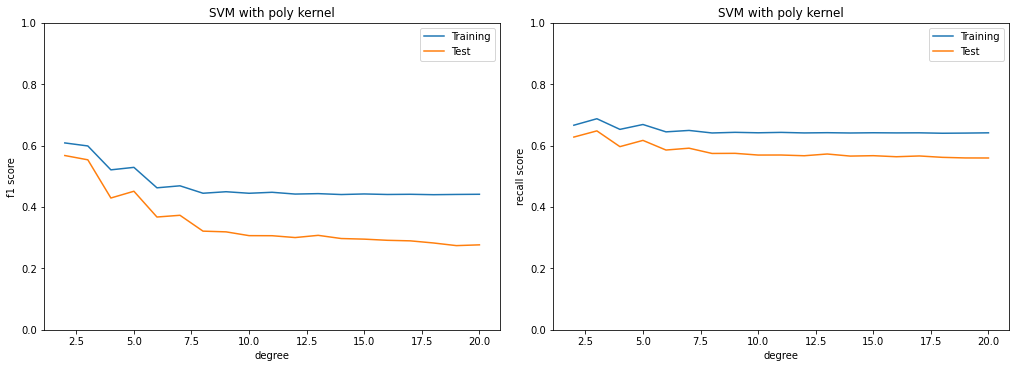

In [15]:
# varying degrees of the kernel
plot_svm_curve(model = 'poly', degrees = degrees)

Observation: \
(1) From the plot on the left side, it can be seen that as the value of degree increases, the $f_{1}$ score gradually decreases while the difference of the $f_{1}$ scores between training and test becomes larger.\
(2) From the plot on the right side, it can be seen that as the degree increases, Recall score almost stays the same with very minor decrease.\
In both cases, the scores have become stable once the value of degree reaches around 10.

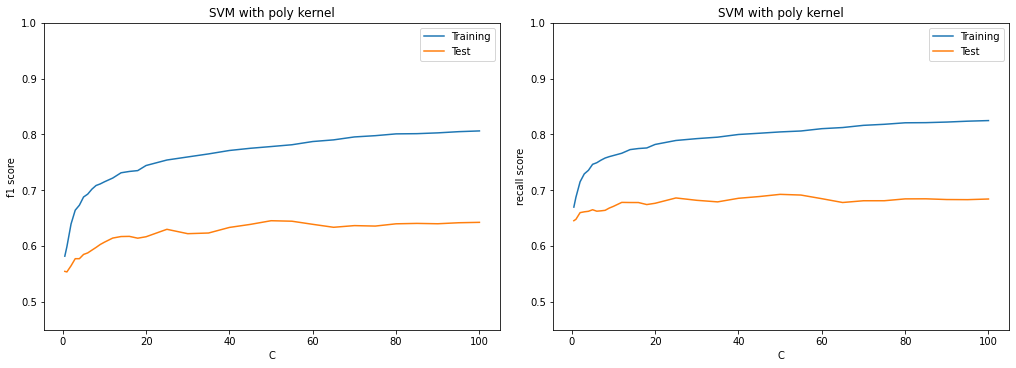

In [16]:
# varying C of the kernel
plot_svm_curve(model = 'poly', Cs = Cs)

Observation: \
(1) From the plot on the left side, it can be seen that as the value of C increases, the $f_{1}$ score gradually increases while the difference of the $f_{1}$ scores between training and test becomes larger. Moreover, the increase in C has a larger effect on the training score than the test score.\
(2) From the plot on the right side, a similar observation can be made: as C increases, Recall score increases and the difference of the Recall scores between training and test widens. Meanwhile, the increase in C has a much larger effect on the training score than the test score.\
In both cases, the scores have become stable once C reaches around 50.

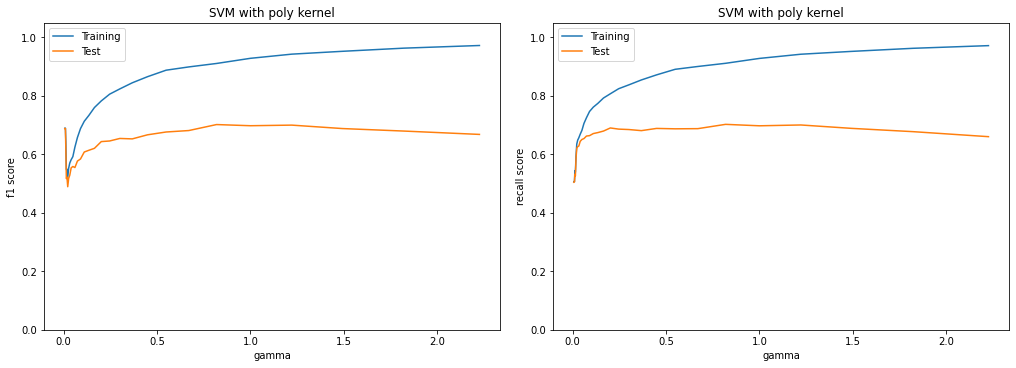

In [17]:
# varying gamma of the kernel
plot_svm_curve(model = 'poly', gammas = gammas)

Observation: \
(1) From the plot on the left side, it can be seen that as the value of gamma increases, the $f_{1}$ score gradually increases (except when the value of gamma was very low) while the difference of the $f_{1}$ scores between training and test becomes larger. Moreover, the increase in gamma has a larger effect on the training score than the test score.\
(2) From the plot on the right side, a similar observation can be made: as gamma increases, Recall score increases and the difference of the Recall scores between training and test widens. Meanwhile, the increase in gamma has a larger effect on the training score than the test score.\
In both cases, the scores have become stable once gamma reaches around 1.2.

### Plottings of models using rbf kernel with varying hyperparameters (metrics: $f_{1}$ and Recall scores)

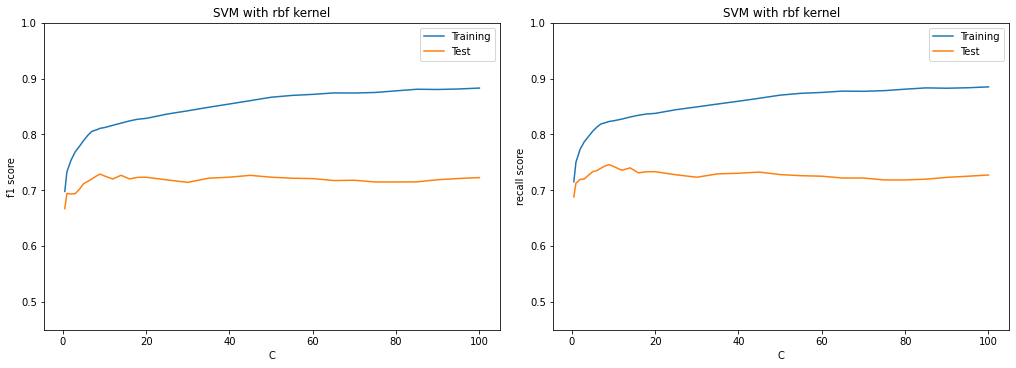

In [18]:
# varying C of the kernel
plot_svm_curve(model = 'rbf', Cs = Cs)

Observation: \
(1) From the plot on the left side, it can be seen that as the value of C increases, the $f_{1}$ score gradually increases while the difference of the $f_{1}$ scores between training and test becomes larger. Moreover, the increase in C has a much larger effect on the training score than the test score.\
(2) From the plot on the right side, a similar observation can be made: as C increases, Recall score increases and the difference of the Recall scores between training and test widens. Meanwhile, the increase in C has a larger effect on the training score than the test score.\
In both cases, the scores have become stable once C reaches around 50.

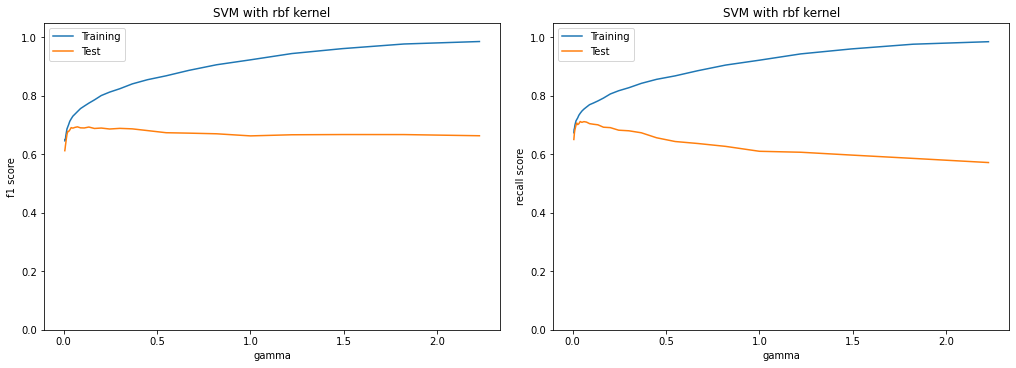

In [19]:
# varying gamma of the kernel
plot_svm_curve(model = 'rbf', gammas = gammas)

Observation: \
(1) From the plot on the left side, it can be seen that as the value of gamma increases, the training $f_{1}$ score increases while the test $f_{1}$ score stays almost the same.\
(2) From the plot on the right side, it can be seen that as gamma increases, the training Recall score increases while the test Recall score decreases.

In [20]:
time_spend = time.time() - start
print('time spent: ', time_spend)

time spent:  240.0345687866211


### Part 3 Analysis

With this new combination, it can be seen that Recall also behaves similarly to the $f_{1}$ score. As seen on the threshold of Recall's gamma, it is really sensitive to overfitting. The graphs show a larger gap between training and test data as gamma increases - not just because the training results get too good, but because the test results get worse. 


## Part 4. Gridsearch
With our preliminary results, we will follow the following approach to our gridsearch:
- Restricting gammas and degrees to lower ranges. 
- In general C appears better in the higher ranges, but it will not be strictly limited, as it is still unclear.

### Gridsearch for different types of kernels and different hyperparameters using $f_{1}$ score as the standard

In [21]:
# define ranges of hyperparameters
Cs = np.array([ 35. ,  45. ,  55. ,  65. ,  75. ,
                80. ,  85. ,  90. ,  95. , 100. ])
gammas = np.array([0.00673795, 0.01005184, 0.01499558,
       0.01831564, 0.02732372, 0.0407622 ,
       0.04978707, 0.07427358, 0.09071795, 0.13533528, 0.16529889])
degrees = np.array([2,  3,  4,  5])

param_grid = {'kernel' : ['poly', 'rbf', 'linear', 'sigmoid'],
              'C' : Cs,
              'gamma' : gammas,
              'degree' : degrees}             

scoring = {'Accuracy' : 'accuracy',
           'Precision' : 'precision', 
           'recall' : recall,
           'f1' : f1, 
           'f2' : f2}

# fit training data using GridSearch and cross validation
start = time.time()
svm_ = svm.SVC()
CV_svm = GridSearchCV(estimator = svm_, param_grid = param_grid, cv = 5, 
                      scoring = scoring, refit = 'f1')
CV_svm.fit(X_train, y_train)

time_spend = time.time() - start
print('time spent: ', time_spend)

time spent:  1143.2461256980896


In [22]:
# A DataFrame to keep track of the results
params_ = CV_svm.cv_results_['params']
result = {k : [dic[k] for dic in params_] for k in params_[0]}
cln = ['kernel', 'C', 'gamma', 'degree']

for i in ['f1', 'recall']: # 'Accuracy', 'Precision', and 'recall'
                           # are left out here for the report
    result['mean_test_' + i] = CV_svm.cv_results_['mean_test_' + i]
    result['std_test_' + i] = CV_svm.cv_results_['std_test_' + i]
    cln.append('mean_test_' + i)

results = pd.DataFrame(result)

# replace the hyperparameters that are not applicable 
# for certain kernels with NaN values
results.loc[results.kernel == 'linear', ['degree', 'gamma']] = np.nan
results.loc[results.kernel == 'rbf', 'degree'] = np.nan
results.loc[results.kernel == 'sigmoid', 'degree'] = np.nan

#### Find hyperparameter combo that optimizes $f_{1}$

In [23]:
# sort results using the f1 score and drop duplicate values
results_sorted1 = results.sort_values('mean_test_f1', ascending = False)
results_sorted1.drop_duplicates(subset = results_sorted1.columns[3:], 
                                inplace = True) 

display(results_sorted1.head(10))

,C,degree,gamma,kernel,mean_test_f1,std_test_f1,mean_test_recall,std_test_recall
897,80.0,NaN,0.027324,rbf,0.744634,0.025052,0.755057,0.021107
1553,95.0,NaN,0.018316,rbf,0.741349,0.033060,0.754313,0.028125
1597,100.0,NaN,0.018316,rbf,0.741197,0.035452,0.754313,0.029411
1161,85.0,NaN,0.027324,rbf,0.740732,0.025985,0.750607,0.022274
1381,90.0,NaN,0.027324,rbf,0.740547,0.030365,0.749378,0.027966
1065,85.0,NaN,0.014996,rbf,0.740370,0.035987,0.756978,0.028340
1549,95.0,NaN,0.014996,rbf,0.740284,0.040092,0.756978,0.032125
809,75.0,NaN,0.027324,rbf,0.739550,0.027159,0.750796,0.022982
1725,100.0,NaN,0.014996,rbf,0.739486,0.041260,0.755841,0.033783
1329,90.0,NaN,0.014996,rbf,0.739418,0.039184,0.755841,0.031009


### Gridsearch for different types of kernels and different hyperparameters using Recall score as the standard

In [24]:
start = time.time()

# fit training data using GridSearch and cross validation
svm_2 = svm.SVC()
CV_svm2 = GridSearchCV(estimator = svm_2, param_grid = param_grid, cv = 5, 
                       scoring = scoring, refit = 'recall')
CV_svm2.fit(X_train, y_train)

time_spend = time.time() - start
print('time spent: ', time_spend)

time spent:  1142.1205389499664


In [25]:
# A DataFrame to keep track of the results
params_2 = CV_svm2.cv_results_['params']
result2 = {k : [dic[k] for dic in params_] for k in params_[0]}
cln = ['kernel', 'C', 'gamma', 'degree']

for i in ['f1', 'recall']: # 'Accuracy', 'Precision', and 'recall'
                           # are left out here for the report
    result2['mean_test_' + i] = CV_svm2.cv_results_['mean_test_' + i]
    result2['std_test_' + i] = CV_svm2.cv_results_['std_test_' + i]
    cln.append('mean_test_' + i)

results2 = pd.DataFrame(result2)

# replace the hyperparameters that are not applicable 
# for certain kernels with NaN values
results2.loc[results.kernel == 'linear', ['degree', 'gamma']] = np.nan
results2.loc[results.kernel == 'rbf', 'degree'] = np.nan
results2.loc[results.kernel == 'sigmoid', 'degree'] = np.nan

#### Find hyperparameter combo that optimizes recall

In [26]:
# sort results using the Recall score and drop duplicate values
results2.drop_duplicates(inplace = True) 
results_sorted2 = results2.sort_values('mean_test_recall', ascending = False)

display(results_sorted2.head(10))

,C,degree,gamma,kernel,mean_test_f1,std_test_f1,mean_test_recall,std_test_recall
1585,100.0,NaN,0.006738,rbf,0.737507,0.037810,0.757475,0.031416
889,80.0,NaN,0.014996,rbf,0.739284,0.036059,0.757167,0.029002
1417,95.0,NaN,0.014996,rbf,0.740284,0.040092,0.756978,0.032125
1065,85.0,NaN,0.014996,rbf,0.740370,0.035987,0.756978,0.028340
706,75.0,NaN,NaN,linear,0.738127,0.032489,0.756123,0.027576
189,45.0,NaN,0.018316,rbf,0.738587,0.032866,0.756041,0.027056
1593,100.0,NaN,0.014996,rbf,0.739486,0.041260,0.755841,0.033783
1241,90.0,NaN,0.014996,rbf,0.739418,0.039184,0.755841,0.031009
713,75.0,NaN,0.014996,rbf,0.735809,0.035984,0.755189,0.028965
1586,100.0,NaN,NaN,linear,0.735972,0.030761,0.755176,0.024985


### Part 4 Analysis

On our gridsearch, no model is a clear winner for everyone. For a data scientist, the model with the best $f_{1}$ score might be the best one, whereas the model with the best Recall score might be the best for the medical team. To find a balance, the $f_{3}$ score could possibly be used. The $f_{3}$ score has a focus on the $f_{1}$ score but also weighs Recall over Precision.

Overall, the optimization led to a similar score for both metrics. From a model perspective, RBF and linear kernels outperformed polynomial and sigmoid kernels. Regarding the hyperparameters, C values over 60 and a gamma below 0.02 appear to be optimal. Further tuning with a narrower range of values could improve these results. 

## Part 5. Second round of tuning based on previous observations

In [27]:
del Cs, gammas, param_grid, scoring

# define narrower ranges for hyperparameters for the
# second round
Cs = np.array([ 60. , 70. , 80. , 90. , 100. , 110.])
gammas = np.array([0.001, 0.0025, 0.004, 0.0055, 0.007, 
                   0.0085, 0.01, 0.02, 0.03])

param_grid = {'kernel' : ['rbf', 'linear'],
              'C' : Cs,
              'gamma' : gammas}        

scoring = {'Accuracy' : 'accuracy',
           'Precision' : 'precision', 
           'recall' : recall,
           'f1' : f1, 
           'f2' : f2}

### Second tuning using $f_{1}$ score as metric

In [28]:
start = time.time()

# fit training data using GridSearch and cross validation
svm_3 = svm.SVC()
CV_svm3 = GridSearchCV(estimator = svm_3, param_grid = param_grid, cv = 5, 
                      scoring = scoring, refit = 'f1')
CV_svm3.fit(X_train, y_train)

time_spend = time.time() - start
print('time spent: ', time_spend)

time spent:  124.04504299163818


In [29]:
# A DataFrame to keep track of the results
params_ = CV_svm3.cv_results_['params']
result3 = {k : [dic[k] for dic in params_] for k in params_[0]}
cln = ['kernel', 'C', 'gamma', 'degree']

for i in ['f1', 'recall']: # 'Accuracy', 'Precision', and 'recall'
                           # are left out here for the report
    result3['mean_test_' + i] = CV_svm3.cv_results_['mean_test_' + i]
    result3['std_test_' + i] = CV_svm3.cv_results_['std_test_' + i]
    cln.append('mean_test_' + i)

results3 = pd.DataFrame(result3)

# replace the hyperparameters that are not applicable 
# for certain kernels with NaN values
results3.loc[results3.kernel == 'linear', ['degree', 'gamma']] = np.nan
results3.loc[results3.kernel == 'rbf', 'degree'] = np.nan
results3.loc[results3.kernel == 'sigmoid', 'degree'] = np.nan

# sort results using the Recall score and drop duplicate values
results_sorted3 = results3.sort_values('mean_test_f1', ascending = False)
results_sorted3.drop_duplicates(subset = results_sorted3.columns[3:], inplace = True) 

display(results_sorted3.head(10))

,C,gamma,kernel,mean_test_f1,std_test_f1,mean_test_recall,std_test_recall,degree
104,110.0,0.0200,rbf,0.744233,0.035829,0.756399,0.031679,NaN
68,90.0,0.0200,rbf,0.740693,0.036042,0.754421,0.030758,NaN
106,110.0,0.0300,rbf,0.740539,0.029553,0.745709,0.034475,NaN
34,70.0,0.0300,rbf,0.740258,0.026635,0.750714,0.024345,NaN
16,60.0,0.0300,rbf,0.739809,0.030668,0.752053,0.027206,NaN
86,100.0,0.0200,rbf,0.739752,0.040647,0.753274,0.034925,NaN
100,110.0,0.0085,rbf,0.739305,0.033930,0.757188,0.027309,NaN
50,80.0,0.0200,rbf,0.739027,0.034670,0.752135,0.029342,NaN
32,70.0,0.0200,rbf,0.738039,0.034423,0.753555,0.028357,NaN
66,90.0,0.0100,rbf,0.737180,0.035185,0.755000,0.029716,NaN


### Second tuning for recall

In [30]:
start = time.time()

# fit training data using GridSearch and cross validation
svm_4 = svm.SVC()
CV_svm4 = GridSearchCV(estimator = svm_4, param_grid = param_grid, cv = 5, 
                      scoring = scoring, refit = 'recall')
CV_svm4.fit(X_train, y_train)

time_spend = time.time() - start
print('time spent: ', time_spend)

time spent:  124.1988878250122


In [31]:
# A DataFrame to keep track of the results
params_ = CV_svm4.cv_results_['params']
result4 = {k : [dic[k] for dic in params_] for k in params_[0]}
cln = ['kernel', 'C', 'gamma', 'degree']

for i in ['f1', 'recall']: # 'Accuracy', 'Precision', and 'recall'
                           # are left out here for the report
    result4['mean_test_' + i] = CV_svm4.cv_results_['mean_test_' + i]
    result4['std_test_' + i] = CV_svm4.cv_results_['std_test_' + i]
    cln.append('mean_test_' + i)

results4 = pd.DataFrame(result4)

# replace the hyperparameters that are not applicable 
# for certain kernels with NaN values
results4.loc[results4.kernel == 'linear', ['degree', 'gamma']] = np.nan
results4.loc[results4.kernel == 'rbf', 'degree'] = np.nan
results4.loc[results4.kernel == 'sigmoid', 'degree'] = np.nan

# sort results using the Recall score and drop duplicate values
results_sorted4 = results4.sort_values('mean_test_recall', ascending = False)
results_sorted4.drop_duplicates(subset = results_sorted4.columns[3:], inplace = True) 

display(results_sorted4.head(10))

,C,gamma,kernel,mean_test_f1,std_test_f1,mean_test_recall,std_test_recall,degree
100,110.0,0.0085,rbf,0.739305,0.033930,0.757188,0.027309,NaN
104,110.0,0.0200,rbf,0.744233,0.035829,0.756399,0.031679,NaN
98,110.0,0.0070,rbf,0.736751,0.034208,0.756349,0.028358,NaN
80,100.0,0.0070,rbf,0.736671,0.038448,0.756338,0.032170,NaN
24,70.0,0.0055,rbf,0.732901,0.036666,0.755699,0.031023,NaN
62,90.0,0.0070,rbf,0.735112,0.038137,0.755297,0.031156,NaN
79,100.0,NaN,linear,0.735972,0.030761,0.755176,0.024985,NaN
66,90.0,0.0100,rbf,0.737180,0.035185,0.755000,0.029716,NaN
68,90.0,0.0200,rbf,0.740693,0.036042,0.754421,0.030758,NaN
1,60.0,NaN,linear,0.734581,0.030616,0.754156,0.024890,NaN


### Part 5 Analysis
The final hyperparameters after this round of tuning are:

Metric | Kernel | C | gamma
--- | --- | --- | ---
$f_{1}$ score | rbf  | 110  | 0.02
Recall score  | rbf  | 110  | 0.0085

## Part 6. Confusion matrix

### Using $f_{1}$ score as metric

In [32]:
# We use the best one for f1:
results_sorted3 = results_sorted3.reset_index(drop=True)
print(results_sorted3.loc[0, ['C', 'gamma', 'kernel']])

# fit the training data again with this "best"
# combination of hyperparameters
svm_bestf1 = svm.SVC(C = results_sorted3.loc[0, 'C'], 
                     gamma = results_sorted3.loc[0, 'gamma'],
                     kernel = results_sorted3.loc[0, 'kernel'])
svm_bestf1.fit(X_train, y_train)

# use model to predict using test data
y_train_pred = svm_bestf1.predict(X_train)
y_test_pred = svm_bestf1.predict(X_test)

# construct confusion matrix
conf_mat_train = confusion_matrix(y_train, y_train_pred)
conf_mat_test = confusion_matrix(y_test, y_test_pred)

# calculate f1 scores
f1_train = f1_scorer(y_train, y_train_pred)
f1_test = f1_scorer(y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)
print('f1 score of training sample: ', f1_train)
print('f1 score of test sample: ', f1_test)

C         110.0
gamma      0.02
kernel      rbf
Name: 0, dtype: object
Confusion matrix of training sample: 
 [[402  37]
 [121 360]]
Confusion matrix of test sample: 
 [[81 20]
 [42 88]]
f1 score of training sample:  0.8200455580865604
f1 score of test sample:  0.7394957983193278


### Using Recall score as metric

In [33]:
# We use the best one for recall:
results_sorted4 = results_sorted4.reset_index(drop=True)
print(results_sorted4.loc[0, ['C', 'gamma', 'kernel']])

# fit the training data again with this "best"
# combination of hyperparameters
svm_best_rc = svm.SVC(C = results_sorted4.loc[0, 'C'], 
                     gamma = results_sorted4.loc[0, 'gamma'],
                     kernel = results_sorted4.loc[0, 'kernel'])
                     #random_state = 0)
svm_best_rc.fit(X_train, y_train)

# use model to predict using test data
y_train_pred2 = svm_best_rc.predict(X_train)
y_test_pred2 = svm_best_rc.predict(X_test)

# construct confusion matrix
conf_mat_train2 = confusion_matrix(y_train, y_train_pred2)
conf_mat_test2 = confusion_matrix(y_test, y_test_pred2)

# calculate Recall scores
rc_train = recall_scorer(y_train, y_train_pred2)
rc_test = recall_scorer(y_test, y_test_pred2)

print('Confusion matrix of training sample: \n', conf_mat_train2)
print('Confusion matrix of test sample: \n', conf_mat_test2)
print('Recall of training sample: ', rc_train)
print('Recall of test sample: ', rc_test)

C          110.0
gamma     0.0085
kernel       rbf
Name: 0, dtype: object
Confusion matrix of training sample: 
 [[391  48]
 [139 342]]
Confusion matrix of test sample: 
 [[81 20]
 [45 85]]
Recall of training sample:  0.8008396516369182
Recall of test sample:  0.727913175932978


In [34]:
total_time_spend = time.time() - start_0
print('Total time spent: ', total_time_spend)

Total time spent:  3013.7397859096527


### Part 6 Conclusions

Regarding the confusion matrices, we can see a similar behavior for both metrics. We can see that there is an imbalance of false negative and false positive. From a medical perspective, assuming we cannot eliminate false positive or negative results, it is better to have more false positives than false negatives. This is because generally more than one test is performed to determine whether a patient actually has a disease. One good example nowadays is the coronavirus. In many places, the procedure is to perform a quick test and in case of a positive result, perform a pcr test. Having a false negative in this case is worse than false positive. 

Even though the $f_{1}$ and Recall scores have a formidable performance, we cannot ignore the fact that a third of sick patients go undetected. This small dataset does not allow the model to be properly trained and thus accurately diagnose. With more data, we may be able to improve the scores.